In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import linregress

from prosail import run_sail
import gp_emulator

%matplotlib inline

In [2]:
#create inverse transforms

# wrap forward model
def do_FM(albedo, assymetry, lai, rsoil):
    # Go from albeado/assym to reflectance and transmittance
    trans = albedo/(1.0 + assymetry)
    refl = albedo*assymetry/(1.0 + assymetry)
    
    r = np.ones(2101)*refl
    t = np.ones(2101)*trans
    rsoil0 = np.ones(2101)*rsoil
    # Fix following to sensible values
    lidfa = 2
    hspot = 0.01
    # These are sensor angles, - but we will be taking the BHR, which won't be affected by it
    tts=30
    tto=10
    psi=0
    factor = 'BHR'
    bhr = run_sail(r, t, lai, lidfa, hspot, tts, tto, psi, 
                   factor=factor, rsoil0=rsoil0)
    return bhr[0]


In [77]:
def min_from_prior(means, sigmas, limits = [0.0, 1.0]):
    return np.min([mu-3*sd if mu-3*sd>=limits[0] else limits[0] for mu, sd in zip(means, sigmas)])
    
def max_from_prior(means, sigmas, limits = [0.0, 1.0]):
    return np.max([mu+3*sd if mu+3*sd<=limits[1] else limits[1] for mu, sd in zip(means, sigmas)])

which_emulator = 'NIR' #'visible', 'nir', 'both'


# Set up parameter list and min and max params
parameters = ['albedo', 'assymetry', 'LAI', 'rsoil']

# These prior means and sigmas are taken from Pinty et al.
# 'Evaluation of the JRC-TIP 0.01° products over a mid-latitude deciduous forest site'
# Have different priors for NIR and visible spectral domains
# and in some cases for 'green leaf scenario', bare soil or snow
# want to find the range that encompasses all of these scenarios
# if we create one emulator. Alternative is to create seperate priors
# for NIR and IR if these have a narrower range and are faster/
# more accurate.

prior_albedo_mean_vis = [0.17, 0.13] # [normal, green leaf]
prior_albedo_mean_nir = [0.7, 0.77] # [normal, green leaf]
prior_albedo_mean = prior_albedo_mean_vis + prior_albedo_mean_nir
prior_albedo_sigma_vis = [0.12, 0.014]
prior_albedo_sigma_nir = [0.15, 0.014]
prior_albedo_sigma = prior_albedo_sigma_vis + prior_albedo_sigma_nir

prior_assymetry_mean_vis = [1.0]
prior_assymetry_mean_nir = [2.0]
prior_assymetry_mean = prior_assymetry_mean_vis + prior_assymetry_mean_nir
prior_assymetry_sigma_vis = [0.7]
prior_assymetry_sigma_nir = [1.5]
prior_assymetry_sigma = prior_assymetry_sigma_vis + prior_assymetry_sigma_nir

prior_rsoil_mean_vis_bare = 0.1
prior_rsoil_mean_vis_snow = 0.5
prior_rsoil_mean_nir_bare = 0.18
prior_rsoil_mean_nir_snow = 0.35

prior_rsoil_sigma_vis_bare = 0.0959
prior_rsoil_sigma_vis_snow = 0.346
prior_rsoil_sigma_nir_bare = 0.2
prior_rsoil_sigma_nir_snow = 0.25

# I'm not including the snow values in this because 
# I believe we are filtering out snow at the momemnt
prior_rsoil_mean = [prior_rsoil_mean_vis_bare, prior_rsoil_mean_nir_bare]
prior_rsoil_sigma = [prior_rsoil_sigma_vis_bare, prior_rsoil_sigma_nir_bare]

if which_emulator == 'both':
    ##Use all exept snow
    min_assymetry = min_from_prior(prior_assymetry_mean, prior_assymetry_sigma, [0.0, 20])
    max_assymetry = max_from_prior(prior_assymetry_mean, prior_assymetry_sigma, [0.0, 20])

    min_albedo = min_from_prior(prior_albedo_mean, prior_albedo_sigma, [0.0, 1.0])
    max_albedo = max_from_prior(prior_albedo_mean, prior_albedo_sigma, [0.0, 1.0])

    min_rsoil = min_from_prior(prior_rsoil_mean, prior_rsoil_sigma, [0.0, 1.0])
    max_rsoil = max_from_prior(prior_rsoil_mean, prior_rsoil_sigma, [0.0, 1.0])
elif which_emulator == 'vis':
    ## Only visible
    min_assymetry = min_from_prior(prior_assymetry_mean_vis, prior_assymetry_sigma_vis, [0.0, 20])
    max_assymetry = max_from_prior(prior_assymetry_mean_vis, prior_assymetry_sigma_vis, [0.0, 20])

    min_albedo = min_from_prior(prior_albedo_mean_vis, prior_albedo_sigma_vis, [0.0, 1.0])
    max_albedo = max_from_prior(prior_albedo_mean_vis, prior_albedo_sigma_vis, [0.0, 1.0])

    min_rsoil = min_from_prior([prior_rsoil_mean_vis_bare], [prior_rsoil_sigma_vis_bare], [0.0, 1.0])
    max_rsoil = max_from_prior([prior_rsoil_sigma_vis_bare], [prior_rsoil_sigma_vis_bare], [0.0, 1.0])
elif which_emulator == 'NIR':
    ## Only NIR
    min_assymetry = min_from_prior(prior_assymetry_mean_nir, prior_assymetry_sigma_nir, [0.0, 20])
    max_assymetry = max_from_prior(prior_assymetry_mean_nir, prior_assymetry_sigma_nir, [0.0, 20])

    min_albedo = min_from_prior(prior_albedo_mean_nir, prior_albedo_sigma_nir, [0.0, 1.0])
    max_albedo = max_from_prior(prior_albedo_mean_nir, prior_albedo_sigma_nir, [0.0, 1.0])

    min_rsoil = min_from_prior([prior_rsoil_mean_nir_bare], [prior_rsoil_sigma_nir_bare], [0.0, 1.0])
    max_rsoil = max_from_prior([prior_rsoil_sigma_nir_bare], [prior_rsoil_sigma_nir_bare], [0.0, 1.0])

varmin = [min_albedo, min_assymetry,  0.0, min_rsoil]
varmax = [max_albedo, max_assymetry, 10, max_rsoil]





#varmin = [0.001,0.001,0.001,0.001]
#varmax = [1.0, 1.0 , 10.0, 1.5]

print varmin, varmax

[0.25, 0.0, 0.0, 0.0] [1.0, 6.5, 10, 0.80000000000000004]


In [78]:
def simulator(x):
    return do_FM(*x[0])

In [79]:
ntraining = 200
nvalidation = 500
(gp, validate, validation_set, validation_gradient, 
    emulated_validation, emulated_gradient) = gp_emulator.create_emulator_validation(
    simulator, parameters, varmin, varmax, ntraining, nvalidation)

After 5, the minimum cost was -3.793822e+02


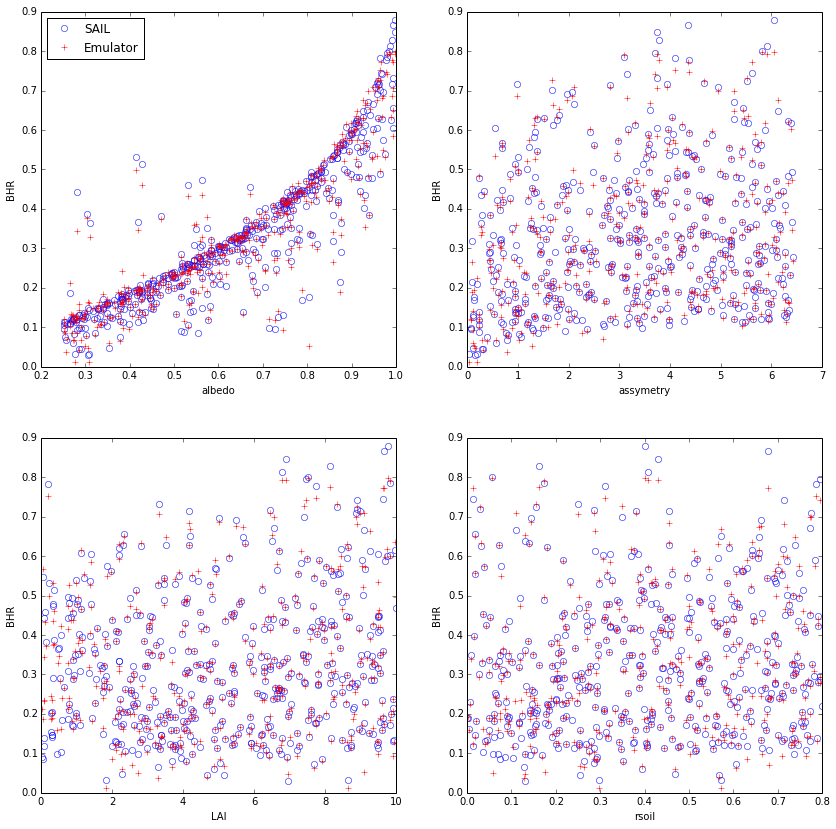

In [83]:
fig, axs = plt.subplots(nrows=2, ncols = 2, figsize = (14,14))
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.plot(validate[:,i], validation_set, 'o', mfc='none', mec='b')
    ax.plot(validate[:,i], emulated_validation, '+', mfc='none', mec='r')
    ax.set_ylabel('BHR')
    ax.set_xlabel(parameters[i])

axs[0].legend( ('SAIL', 'Emulator'), numpoints=1, loc='best')

(0.97963616366721129, 0.0063445497006036078, 0.9929142725916722, 0.0, 0.0052538166577598472)
slope      intercept  R          std err   
0.980      0.006      0.993      0.005     


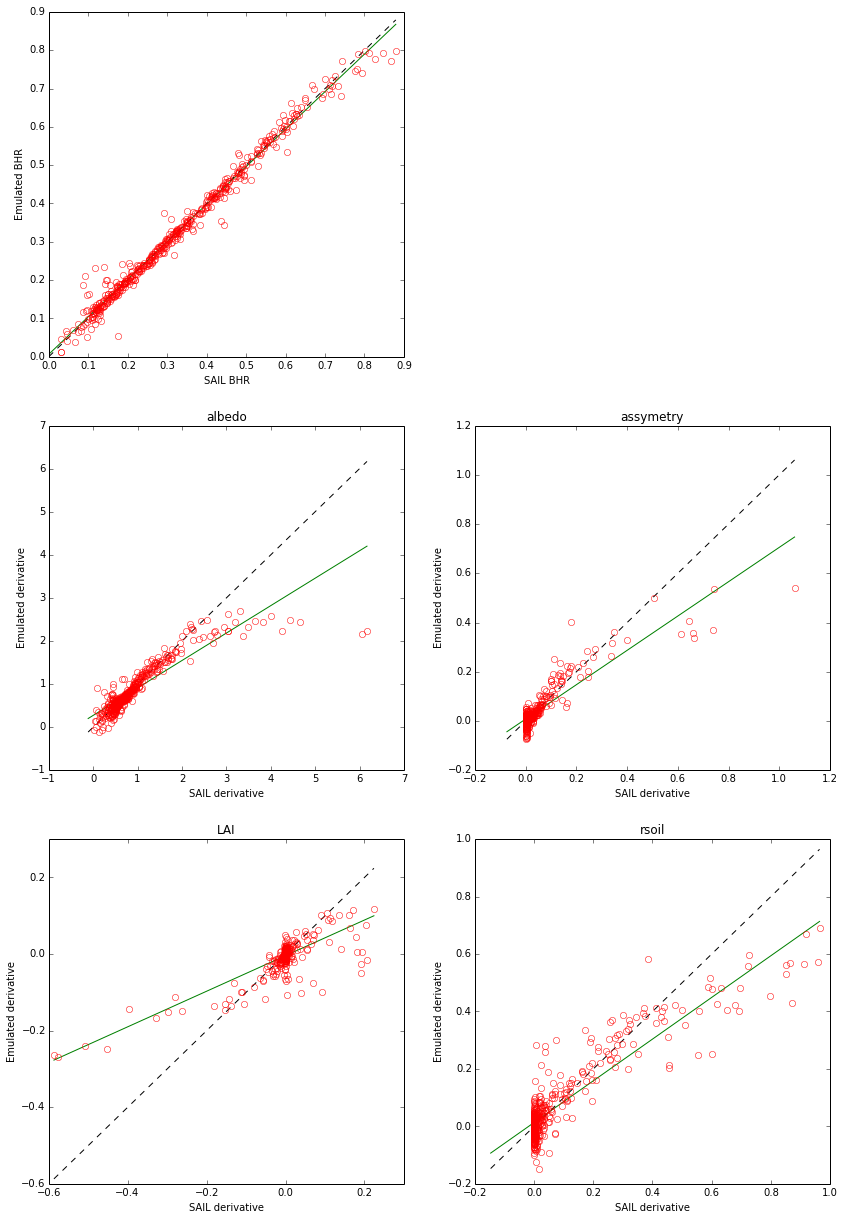

In [85]:
slope, intercept, r_value, p_value, std_err = linregress(
validation_set, emulated_validation.squeeze())
deriv_stats = linregress(validation_set, emulated_validation.squeeze())
print deriv_stats

#print "%6.3f & %6.3f & %6.3f & %6.3e \\\\" % (slope, intercept, r_value, std_err),
print("{:10} {:10} {:10} {:10}".format('slope', 'intercept', 'R', 'std err'))
print("{:<10.3f} {:<10.3f} {:<10.3f} {:<10.3f}".format(slope, intercept, r_value, std_err))

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14,21))
axs = axs.flatten()


def validation_scatter_plot(axes, original, emulation, labels=['Original', 'Emulated']):
    max_x = np.max((original.max(), emulation.max(), 0.0))
    min_x = np.min((original.min(), emulation.min(), 0.0))
    p = np.polyfit(original, emulation, 1)
    x = np.linspace(min_x, max_x, 5)
    axes.plot(x, np.polyval(p, x), '-g')
    axes.plot([min_x, max_x], [min_x, max_x], 'k--')
    axes.plot(original, emulation, 'o', mfc='none', mec='r')
    axes.set_xlabel(labels[0])
    axes.set_ylabel(labels[1])
'''    
for i in xrange(4):
    print i
    print np.max((validation_gradient[:,i].max(), emulated_gradient[:,i].max()))
    print np.min((validation_gradient[:,i].min(), emulated_gradient[:,i].min()))
#max_test = np.max(validation_gradient[:,i].max(), emulated_gradient[:,i].max())
'''

validation_scatter_plot(axs[0], validation_set, emulated_validation, ['SAIL BHR', 'Emulated BHR'])
axs[1].axis('off')
for i in xrange(4):
    labels = ['SAIL derivative', 'Emulated derivative']
    validation_scatter_plot(axs[i+2], validation_gradient[:,i], emulated_gradient[:,i], labels)
    axs[i+2].set_title(parameters[i])
    #print(emulated_gradient[:,i])



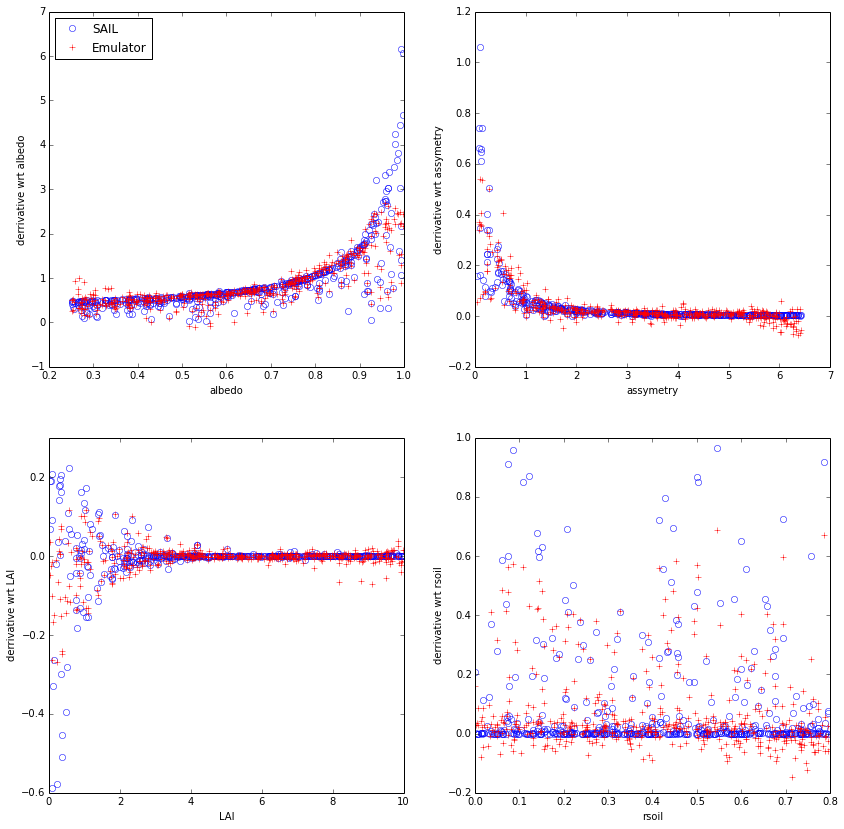

In [86]:
fig, axs = plt.subplots(nrows=2, ncols = 2, figsize = (14,14))
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.plot(validate[:,i], validation_gradient[:,i], 'o', mfc='none', mec='b')
    ax.plot(validate[:,i], emulated_gradient[:,i], '+', mfc='none', mec='r')
    ax.set_ylabel('derrivative wrt {}'.format(parameters[i]))
    ax.set_xlabel(parameters[i])

axs[0].legend( ('SAIL', 'Emulator'), numpoints=1, loc='best')

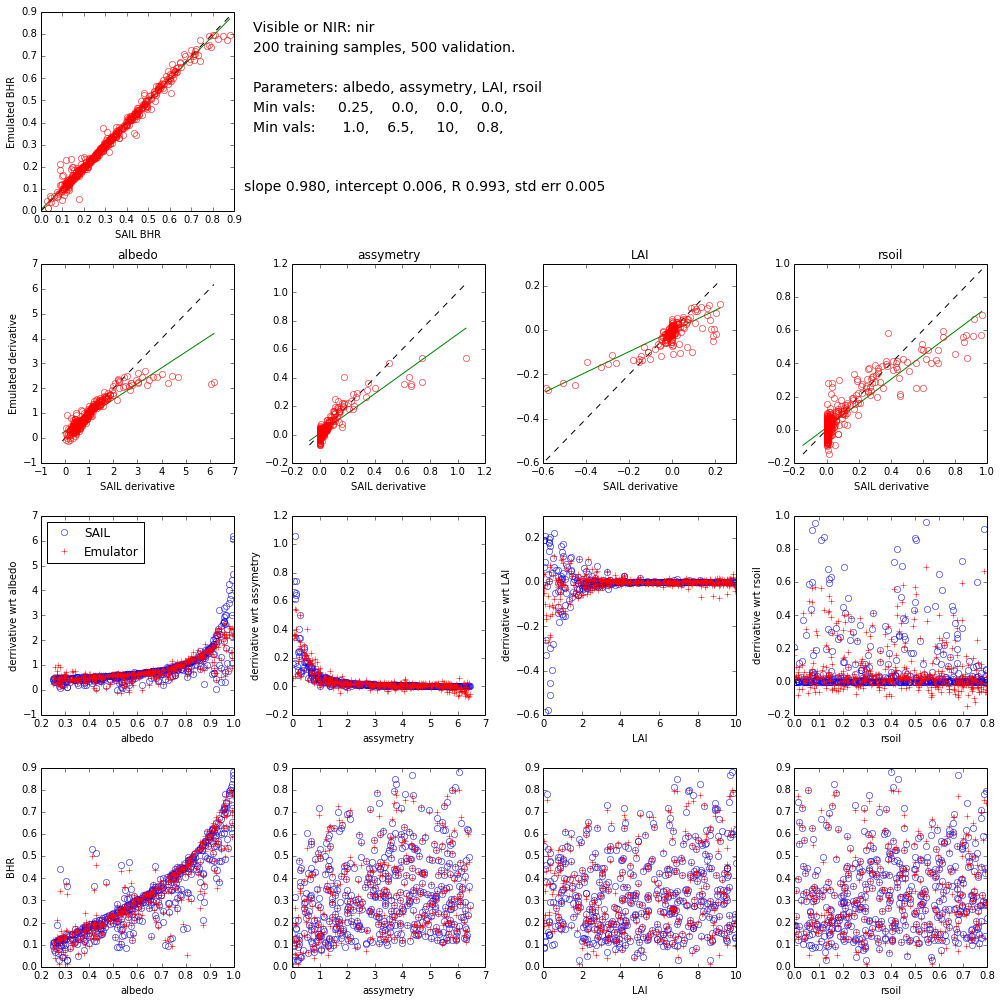

In [92]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(14,14))
#axs = axs.flatten()

validation_scatter_plot(axs[0][0], validation_set, emulated_validation, ['SAIL BHR', 'Emulated BHR'])
for i in xrange(1,4):
    axs[0,i].axis('off')
for i in xrange(4):
    labels = ['SAIL derivative', 'Emulated derivative']
    ax = axs[1][i]
    validation_scatter_plot(ax, validation_gradient[:,i], emulated_gradient[:,i], labels)
    ax.set_title(parameters[i])
    #print(emulated_gradient[:,i])
    
    ax = axs[2][i]
    ax.plot(validate[:,i], validation_gradient[:,i], 'o', mfc='none', mec='b')
    ax.plot(validate[:,i], emulated_gradient[:,i], '+', mfc='none', mec='r')
    ax.set_ylabel('derrivative wrt {}'.format(parameters[i]))
    ax.set_xlabel(parameters[i])

    ax = axs[3][i]
    
    ax.plot(validate[:,i], validation_set, 'o', mfc='none', mec='b')
    ax.plot(validate[:,i], emulated_validation, '+', mfc='none', mec='r')
    ax.set_xlabel(parameters[i])
    
axs[2][0].legend( ('SAIL', 'Emulator'), numpoints=1, loc='best')
axs[3][0].set_ylabel('BHR')
for i in xrange(1,4): 
    axs[1][i].set_ylabel('')

results = "slope {:<.3f}, intercept {:<.3f}, R {:<.3f}, std err {:<.3f}".format(slope, intercept, r_value, std_err)
    
axs[0][1].text(-0.25,0.1, results, fontsize=14)

axs[0][1].text(-0.2,0.9, 'Visible or NIR: {}'.format(which_emulator), fontsize=14)
axs[0][1].text(-0.2,0.8, '{} training samples, {} validation.'.format(ntraining, nvalidation), fontsize=14)
axs[0][1].text(-0.2,0.6, 'Parameters: {}, {}, {}, {}'.format(*parameters), fontsize=14)
axs[0][1].text(-0.2,0.5, 'Min vals:   {:6}, {:6}, {:6}, {:6},'.format(*varmin), fontsize=14)
axs[0][1].text(-0.2,0.4, 'Min vals:   {:6}, {:6}, {:6}, {:6},'.format(*varmax), fontsize=14)


fig.tight_layout()

# This was to do the gp without using create_emulator_validation

In [116]:
#create training set
training_set, distributions = gp_emulator.create_training_set(
    parameters, varmin, varmax, n_train = 100)

In [117]:
#Checking things cell:
print(training_set.shape)
tmp = distributions[0]


(100, 4)


In [8]:
#run the FM for each training set
bhr_training = np.array([do_FM(*x) for x in training_set])
#bhr_training = np.array(bhr_training)
print bhr_training
print(bhr_training.shape)

[  1.34125046e-01   1.97771374e-02   2.94721963e-02   9.66768984e-02
   2.73676291e-01   9.30176723e-02   2.81628356e-02   4.18618835e-02
   4.15423215e-01   1.09566747e-01   1.26326770e-01   1.53984214e-02
   1.84661186e-01   2.79429181e-01   1.39775826e-01   4.93284272e-02
   2.22270364e-02   3.17020830e-01   4.31729479e-01   2.71729091e-02
   4.98356802e-01   4.46031585e-01   2.20762495e-01   3.57544633e-01
   9.45838863e-02   3.59336204e-01   9.73529722e-02   3.87138996e-02
   1.83635622e-01   8.11256016e-02   6.71800473e-04   3.32063774e-03
   1.00826615e-01   5.61498143e-02   2.71620988e-01   1.74105970e-01
   1.80383813e-03   4.82082383e-01   3.27018575e-02   4.27034024e-02
   6.44656080e-02   1.13976998e-01   4.95792429e-01   1.47674911e-01
   1.26648477e-01   1.20108650e-02   3.52133807e-01   3.44286988e-02
   2.37156799e-01   1.09831497e-01   2.10144114e-01   1.07125278e-01
   4.19424700e-01   6.42328755e-02   1.16857250e-01   2.26517849e-01
   3.86990610e-01   9.95063762e-03

In [9]:
#create the emulator
gp = gp_emulator.GaussianProcess(training_set, bhr_training)
gp.learn_hyperparameters(n_tries = 5)

After 5, the minimum cost was -2.484794e+02


(-248.47937240346812,
 array([  1.24833648,  -1.11916461,  -2.56589529, -34.1771215 ,
          0.47200515, -12.99435976]))

In [41]:
gp.basis_functions

array([], shape=(0, 1), dtype=float64)

In [ ]:
#create validation set

In [ ]:
#run FM for each validation set

In [ ]:
#do the validation using gp predict